In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from dolfin import *
import mgis.fenics as mf
import numpy as np
import ufl

In [2]:
K = Constant(3.61e6)
alpha_y = Constant(0.28)
alpha_g = Constant(0.25)
E = Constant(3.82e9)
v = Constant(0.315)

In [3]:
x0 = 0.0
x1 = 1
y0 = 0.0
y1 = 1
nx = 2
ny = 2
mesh = RectangleMesh(Point(x0, y0), Point(x1, y1), nx, ny, 'crossed')

In [4]:
### Boundary Conditions ###
class LeftBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0],x0) and on_boundary
left_boundary = LeftBoundary()

class RightBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0],x1) and on_boundary
right_boundary = RightBoundary()

class BottomBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1],y0) and on_boundary
bottom_boundary = BottomBoundary()

class TopBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1],y1) and on_boundary
top_boundary = TopBoundary()

boundary_facet_function = MeshFunction('size_t', mesh, 1)
boundary_facet_function.set_all(0) # from 1 
left_boundary.mark(boundary_facet_function,1)
right_boundary.mark(boundary_facet_function,2)
bottom_boundary.mark(boundary_facet_function,3)
top_boundary.mark(boundary_facet_function,4)

ds = Measure("ds")(subdomain_data=boundary_facet_function)

In [5]:
V  = VectorFunctionSpace(mesh, 'CG', 1)
Ve = TensorFunctionSpace(mesh, 'CG', 1)
u  = Function(V)

In [6]:
T = 1
nsteps = 1000
dt = T/nsteps
times = np.linspace(0., T, nsteps+1)

Dis0 =1e-2
cutoff_Tc = T/100
# Define the loading as an expression depending on t
Dis = Expression(("t <= tc ? -Dis0*t/tc : -Dis0"), t=0, tc=cutoff_Tc, Dis0=Dis0, degree=0)

In [7]:
bc1 = DirichletBC(V.sub(0), Constant(0.0), boundary_facet_function, 1)
bc2 = DirichletBC(V.sub(0), Constant(0.0), boundary_facet_function, 2)
bc3 = DirichletBC(V.sub(1), Constant(0.0), boundary_facet_function, 3)
bc4 = DirichletBC(V.sub(1), Dis, boundary_facet_function, 4)
bc = [bc1,bc3,bc4]

In [8]:
mat_prop = {"Cohesion": K,
            "FrictionParameter": alpha_y,
            "DilatancyParameter": alpha_g,
            "YoungModulus": E,
            "PoissonRatio": v,
            }

In [9]:
material = mf.MFrontNonlinearMaterial("src/libBehaviour.so",
                                          "DruckerPrager",
                                          hypothesis="plane_strain",
                                          material_properties=mat_prop)

print(material.behaviour.getBehaviourType())
print(material.behaviour.getKinematic())
print(material.get_gradient_names(), material.get_gradient_sizes())
print(material.get_flux_names(), material.get_flux_sizes())

StandardStrainBasedBehaviour
SmallStrainKinematic
['Strain'] [4]
['Stress'] [4]


In [10]:
problem = mf.MFrontNonlinearProblem(u, material, bcs=bc)

In [11]:
epsel = problem.get_state_variable("ElasticStrain")
print("'ElasticStrain' shape:", ufl.shape(epsel))
sig = problem.get_flux("Stress")
print("'Stress' shape:", ufl.shape(sig))

'ElasticStrain' shape: (4,)
'Stress' shape: (4,)


In [12]:
prm = problem.solver.parameters
prm["absolute_tolerance"] = 1e-6
prm["relative_tolerance"] = 1e-6
prm["linear_solver"] = "mumps"

In [13]:
file_results = XDMFFile("results/DruckerPrager.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

In [14]:
results = np.zeros((nsteps+1, 15))
t= 0.0
for i in range(nsteps):
    t += dt
    print("Time:", t)
    problem.dt = dt
    Dis.t = t
    
    problem.solve(u.vector())
    lam0 = problem.get_state_variable("EquivalentPlasticStrain", project_on=("DG", 0))
    sig = problem.get_flux("Stress", project_on=("DG", 0))
    epsilon = problem.get_gradient("Strain", project_on=("DG", 0))
    
    file_results.write(u, t)
    file_results.write(sig, t)
    file_results.write(epsilon, t)
    
    results[i+1, 0] = u(x1, y1)[0]
    results[i+1, 1] = u(x1, y1)[1]
    results[i+1, 2] = epsilon(x1,y1)[0]
    results[i+1, 3] = epsilon(x1,y1)[1]
    results[i+1, 4] = sig(x1, y1)[0]
    results[i+1, 5] = sig(x1, y1)[1]
    results[i+1, 6] = lam0(x1, y1)

Time: 0.001
Automatic registration of 'Strain' as sym(grad(f_15)).

Automatic registration of 'Temperature' as a Constant value = 293.15.

Time: 0.002
Time: 0.003
Time: 0.004
Time: 0.005
Time: 0.006
Time: 0.007
Time: 0.008
Time: 0.009000000000000001
Time: 0.010000000000000002
Time: 0.011000000000000003
Time: 0.012000000000000004
Time: 0.013000000000000005
Time: 0.014000000000000005
Time: 0.015000000000000006
Time: 0.016000000000000007
Time: 0.017000000000000008
Time: 0.01800000000000001
Time: 0.01900000000000001
Time: 0.02000000000000001
Time: 0.02100000000000001
Time: 0.022000000000000013
Time: 0.023000000000000013
Time: 0.024000000000000014
Time: 0.025000000000000015
Time: 0.026000000000000016
Time: 0.027000000000000017
Time: 0.028000000000000018
Time: 0.02900000000000002
Time: 0.03000000000000002
Time: 0.03100000000000002
Time: 0.03200000000000002
Time: 0.03300000000000002
Time: 0.03400000000000002
Time: 0.035000000000000024
Time: 0.036000000000000025
Time: 0.037000000000000026
Time

Time: 0.32700000000000023
Time: 0.32800000000000024
Time: 0.32900000000000024
Time: 0.33000000000000024
Time: 0.33100000000000024
Time: 0.33200000000000024
Time: 0.33300000000000024
Time: 0.33400000000000024
Time: 0.33500000000000024
Time: 0.33600000000000024
Time: 0.33700000000000024
Time: 0.33800000000000024
Time: 0.33900000000000025
Time: 0.34000000000000025
Time: 0.34100000000000025
Time: 0.34200000000000025
Time: 0.34300000000000025
Time: 0.34400000000000025
Time: 0.34500000000000025
Time: 0.34600000000000025
Time: 0.34700000000000025
Time: 0.34800000000000025
Time: 0.34900000000000025
Time: 0.35000000000000026
Time: 0.35100000000000026
Time: 0.35200000000000026
Time: 0.35300000000000026
Time: 0.35400000000000026
Time: 0.35500000000000026
Time: 0.35600000000000026
Time: 0.35700000000000026
Time: 0.35800000000000026
Time: 0.35900000000000026
Time: 0.36000000000000026
Time: 0.36100000000000027
Time: 0.36200000000000027
Time: 0.36300000000000027
Time: 0.36400000000000027
Time: 0.3650

Time: 0.6520000000000005
Time: 0.6530000000000005
Time: 0.6540000000000005
Time: 0.6550000000000005
Time: 0.6560000000000005
Time: 0.6570000000000005
Time: 0.6580000000000005
Time: 0.6590000000000005
Time: 0.6600000000000005
Time: 0.6610000000000005
Time: 0.6620000000000005
Time: 0.6630000000000005
Time: 0.6640000000000005
Time: 0.6650000000000005
Time: 0.6660000000000005
Time: 0.6670000000000005
Time: 0.6680000000000005
Time: 0.6690000000000005
Time: 0.6700000000000005
Time: 0.6710000000000005
Time: 0.6720000000000005
Time: 0.6730000000000005
Time: 0.6740000000000005
Time: 0.6750000000000005
Time: 0.6760000000000005
Time: 0.6770000000000005
Time: 0.6780000000000005
Time: 0.6790000000000005
Time: 0.6800000000000005
Time: 0.6810000000000005
Time: 0.6820000000000005
Time: 0.6830000000000005
Time: 0.6840000000000005
Time: 0.6850000000000005
Time: 0.6860000000000005
Time: 0.6870000000000005
Time: 0.6880000000000005
Time: 0.6890000000000005
Time: 0.6900000000000005
Time: 0.6910000000000005


Time: 0.9830000000000008
Time: 0.9840000000000008
Time: 0.9850000000000008
Time: 0.9860000000000008
Time: 0.9870000000000008
Time: 0.9880000000000008
Time: 0.9890000000000008
Time: 0.9900000000000008
Time: 0.9910000000000008
Time: 0.9920000000000008
Time: 0.9930000000000008
Time: 0.9940000000000008
Time: 0.9950000000000008
Time: 0.9960000000000008
Time: 0.9970000000000008
Time: 0.9980000000000008
Time: 0.9990000000000008
Time: 1.0000000000000007


<IPython.core.display.Javascript object>


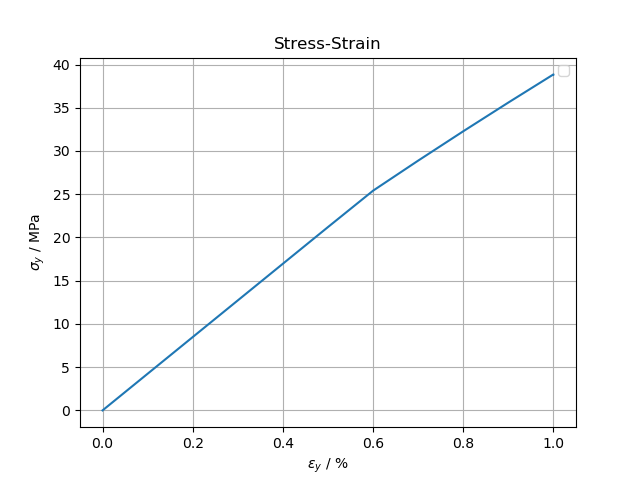

No handles with labels found to put in legend.


In [15]:
plt.figure()
plt.title("Stress-Strain")
plt.plot(-results[:, 3]*100, -results[:, 5]/1e6, "-")
plt.ylabel("$\\sigma_{y}$ / MPa")
plt.xlabel("$\\epsilon_{y}$ / %")
plt.grid()
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


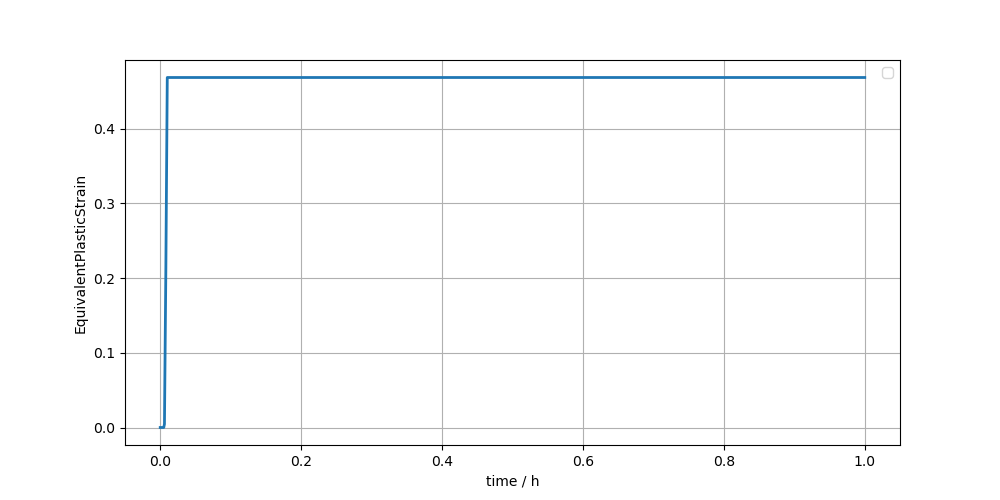

No handles with labels found to put in legend.


In [16]:
plt.figure(figsize=(10.,5))
plt.plot(times, results[:, 6]*100, "-", linewidth = 2)
plt.xlabel("time / h")
plt.ylabel("EquivalentPlasticStrain")
plt.grid()
plt.legend()
plt.show()